# Time-Frequency Image (TFI) Generator
By Fredi R. Mino
April 2021 

# Step 1
Import ```brainflow``` and all other supporting libraries.

In [1]:
import brainflow
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowFunctions

import matplotlib.pyplot as plt

import numpy as np

import os

from scipy import signal

from tifffile import imread, imwrite

## Step 2
Make a list of the files you wish to process. If this is your first time running the script, proceed to section a. Otherwise, move on to section b.

### Section A
List all raw data files present in your data recording directory. Remove specific files by changing the argument in ```filenames.reomve()```

In [2]:
filepath = '../pycharm-projects/'
filenames = []

for file in os.listdir("../pycharm-projects"):
    if file.lower().endswith(".csv"):
        filenames.append(file)

bad_files = ['ses_02_run_01.csv', 'ses_08_run_02.csv', 'ses_12_run_01.csv', 'ses_14_run_03.csv']

for bad_file in bad_files:
    filenames.remove(bad_file)

### Section B
List only the raw data files of a particular session. Change the value of ```ses_num``` accordingly.

In [ ]:
ses_num = 14
filenames = ['ses_{:02d}_run_01.csv'.format(ses_num), 'ses_{:02d}_run_02.csv'.format(ses_num), 'ses_{:02d}_run_03.csv'.format(ses_num)]

## Step 3
Verify the list of files to use in the script.

In [3]:
print(filenames)

['ses_01_run_01.csv', 'ses_01_run_02.csv', 'ses_01_run_03.csv', 'ses_02_run_02.csv', 'ses_02_run_03.csv', 'ses_03_run_01.csv', 'ses_03_run_02.csv', 'ses_03_run_03.csv', 'ses_04_run_01.csv', 'ses_04_run_02.csv', 'ses_04_run_03.csv', 'ses_05_run_01.csv', 'ses_05_run_02.csv', 'ses_05_run_03.csv', 'ses_06_run_01.csv', 'ses_06_run_02.csv', 'ses_06_run_03.csv', 'ses_07_run_01.csv', 'ses_07_run_02.csv', 'ses_07_run_03.csv', 'ses_08_run_01.csv', 'ses_08_run_03.csv', 'ses_09_run_01.csv', 'ses_09_run_02.csv', 'ses_09_run_03.csv', 'ses_10_run_01.csv', 'ses_10_run_02.csv', 'ses_10_run_03.csv', 'ses_11_run_01.csv', 'ses_11_run_02.csv', 'ses_11_run_03.csv', 'ses_12_run_02.csv', 'ses_12_run_03.csv', 'ses_13_run_01.csv', 'ses_13_run_02.csv', 'ses_13_run_03.csv', 'ses_14_run_01.csv', 'ses_14_run_02.csv']


## Step 4
Specify metadata like the sampling frequency used during the recording, the channels you want to process, and the condition labels and the event codes that you want to look at.

In [4]:
eeg_channels = [1, 2, 3, 4, 5, 6, 7, 8]
fs = 250

condition_label = ['none', 'up', 'down', 'left', 'right', 'cross', 'idle']
conditions = [1, 2, 3, 4, 6]

## Step 5
Code adapted from the ```brainflow``` tutorials. For each file, apply all your filters to each channel. Then, find all the time stamps that match the event codes of a particular condition, and make a TFI for each matching time stamp.

In [8]:
for filename in filenames:
    print(filename)
    data = DataFilter.read_file(filepath + filename)
    
    for channel in eeg_channels:
        DataFilter.perform_highpass(data[channel], fs, 0.5, 4, FilterTypes.BUTTERWORTH.value, 0)
        DataFilter.perform_bandstop(data[channel], fs, 60.0, 2.0, 4, FilterTypes.BUTTERWORTH.value, 0)
        DataFilter.perform_bandpass(data[channel], fs, 19.0, 12.0, 4, FilterTypes.BUTTERWORTH.value, 0)
        
    for condition in conditions:
        cond_check = data[-1] == condition
        markers = np.where(cond_check)[0]
    
        if condition_label[condition] == 'idle':
            markers = np.delete(markers, 0)
            markers = np.random.choice(markers, 4, replace=False)
    
        print(markers)
    
        for marker in markers:
            first_channel = True
            for channel in eeg_channels:

                stft_data = data[channel, marker + int(0.5*fs) : marker + int(3.5*fs)].copy()
                f, t, Zxx = signal.stft(stft_data, fs, nperseg = 128, noverlap=127, nfft= 256)
                spectro = np.asarray(Zxx[7:32, :])
                spectro = np.abs(spectro)
                spectro = np.expand_dims(spectro, axis=2)

                if first_channel:
                    spectro_img = spectro.copy()
                    first_channel = False
                else:
                    spectro_img = np.dstack((spectro_img, spectro))
            img_name = f'./img_data/move_{condition_label[condition]}/{filename[0:13]}_{marker}.tif'
            imwrite(img_name, spectro_img, planarconfig='CONTIG')
    print('='*79)

ses_01_run_01.csv
[ 7095 11063 23328 25372]
[ 3007 13107 15151 17195]
[ 9019 19239 21284 29460]
[  963  5051 27416 31504]
[16233  8057  1925  6013]
ses_01_run_02.csv
[  962  9019 23328 29460]
[ 7095 17195 19239 31504]
[ 5051 15151 21283 25372]
[ 3007 11063 13107 27416]
[ 8057 20321 24289 14189]
ses_01_run_03.csv
[ 3007 21283 25372 31504]
[  962  9019 15151 27416]
[11063 17195 19239 29460]
[ 4930  6975 13107 23328]
[ 8057 20201 12145 22245]
ses_02_run_02.csv
[  964  3008  7096 15153]
[17197 21285 23329 31385]
[ 5052  9020 11064 13109]
[19241 25373 27297 29341]
[14191 20203  6014  1926]
ses_02_run_03.csv
[  964  5052  7096 13108]
[ 9020 15153 17197 29461]
[11064 21285 23329 25373]
[ 3008 19241 27417 31506]
[ 6014 28379  1926 10102]
ses_03_run_01.csv
[ 9019 11063 15187 17231]
[  963 25287 29375 31420]
[ 3007  7095 13143 21199]
[ 5051 19275 23243 27331]
[14105 28414 10101  1925]
ses_03_run_02.csv
[  963  5052  9140 13108]
[11184 15152 23328 27417]
[ 7096 17196 19240 29461]
[ 3007 21284 253

[  962  3007 19239 31384]
[ 9019 13107 23328 29340]
[ 4984 17195 21283 27296]
[ 6975 11063 15151 25251]
[22245 30422 26334 28378]
ses_14_run_02.csv
[ 3007  7095 13107 17195]
[11063 21283 27296 31384]
[ 5051  9019 15151 19239]
[  962 23328 25251 29340]
[ 8057  1924 20201 16233]


## Step 6
Verify the shape of the spectrogram, and display one of the channels of the last image that was generated.

(25, 751, 8)


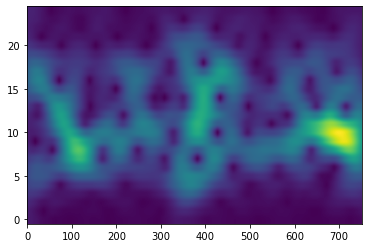

In [9]:
print(spectro_img.shape)

plt.imshow(spectro_img[:,:,0], aspect = 'auto')
plt.gca().invert_yaxis()